<a href="https://colab.research.google.com/github/chernova2601-pixel/miphi_magistratura_chernova/blob/main/%D0%92%D0%B8%D0%B7%D1%83%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

In [2]:
covid_data = pd.read_csv('covid_data.csv')
display(covid_data.head())

,date,province/state,country,confirmed,deaths,recovered
0,01/22/2020,Anhui,China,1.0,0.0,0.0
1,01/22/2020,Beijing,China,14.0,0.0,0.0
2,01/22/2020,Chongqing,China,6.0,0.0,0.0
3,01/22/2020,Fujian,China,1.0,0.0,0.0
4,01/22/2020,Gansu,China,0.0,0.0,0.0


In [3]:
vaccinations_data = pd.read_csv('country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations',
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]
vaccinations_data.head(3)

,country,date,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines
0,Afghanistan,2021-02-22,0.0,0.0,0.0,NaN,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
1,Afghanistan,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
2,Afghanistan,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."


Группируем таблицу по дате и названию страны и рассчитываем суммарные показатели по всем регионам. Тем самым переходим от данных по регионам к данным по странам:

In [4]:
covid_data = covid_data.groupby(
    ['date', 'country'],
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum()

2
Преобразуем даты в формат datetime с помощью функции pd.to_datetime():

In [5]:
covid_data['date'] = pd.to_datetime(covid_data['date'])

Создадим признак больных на данный момент (active). Для этого вычтем из общего числа зафиксированных случаев число смертей и число выздоровевших пациентов:

In [6]:
covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

Создадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей. Для этого отсортируем данные по названиям стран, а затем по датам. После этого произведём группировку по странам и рассчитаем разницу между «вчера и сегодня» с помощью метода diff():

In [7]:
covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()

В таблице vaccinations_data достаточно будет преобразовать столбцы в формат datetime:

In [8]:
vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])

In [9]:
vaccinations_data['date'].max()

Timestamp('2021-09-06 00:00:00')

In [10]:
vaccinations_data['date'].min()

Timestamp('2020-12-02 00:00:00')

In [11]:
covid_df=covid_data.merge(
    vaccinations_data,
    left_on=(['country','date']),
    right_on=(['country','date']),
    how='left'
)
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86785 entries, 0 to 86784
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 86785 non-null  datetime64[ns]
 1   country                              86785 non-null  object        
 2   confirmed                            86785 non-null  float64       
 3   deaths                               86785 non-null  float64       
 4   recovered                            86785 non-null  float64       
 5   active                               86785 non-null  float64       
 6   daily_confirmed                      86564 non-null  float64       
 7   daily_deaths                         86564 non-null  float64       
 8   daily_recovered                      86564 non-null  float64       
 9   total_vaccinations                   10629 non-null  float64       
 10  people_vac

In [12]:
covid_df['death_rate']=(covid_df['deaths']/covid_df['confirmed']*100).round(2)
covid_df['recover_rate']=(covid_df['recovered']/covid_df['confirmed']*100).round(2)

In [13]:
max_USA=covid_df.groupby('country')['death_rate'].max()
max_USA['United States']

np.float64(7.19)

In [14]:
mean_RU=(covid_df.groupby('country')['recover_rate'].mean()).round(2)
mean_RU['Russia']

np.float64(67.06)

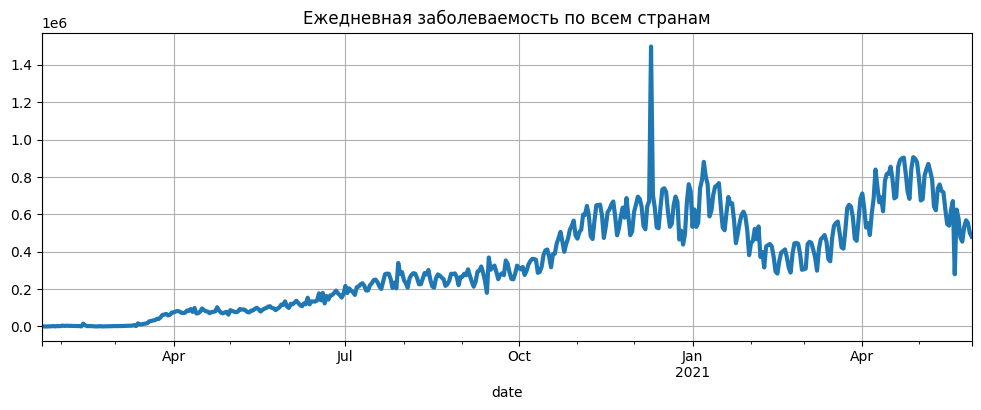

In [15]:
grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind='line',
    figsize=(12, 4),
    title='Ежедневная заболеваемость по всем странам',
    grid = True,
    lw=3
);

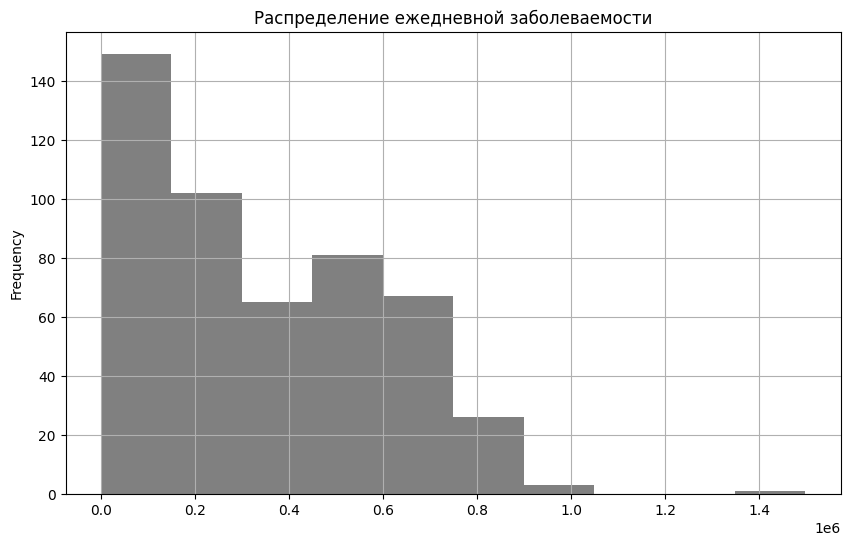

In [16]:
grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind='hist',
    figsize=(10, 6),
    title='Распределение ежедневной заболеваемости',
    grid = True,
    color = 'grey',
    bins=10
);

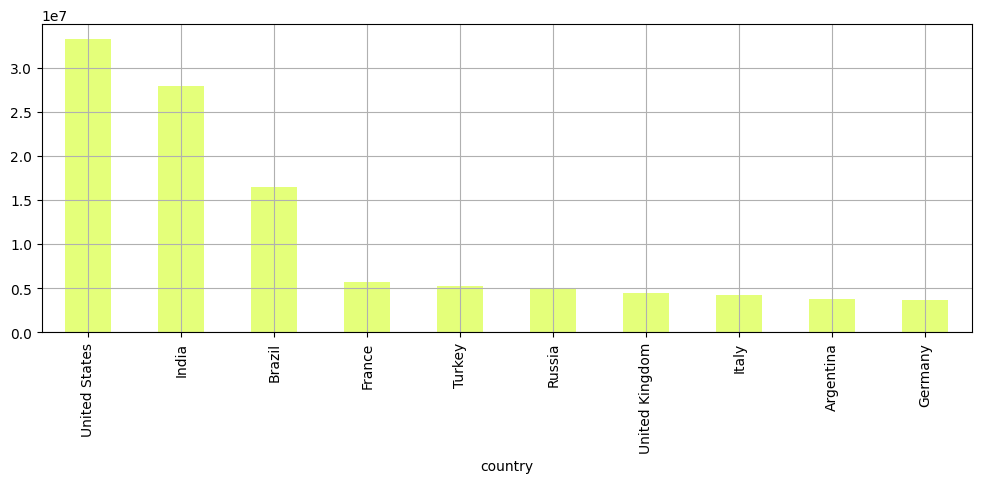

In [17]:
grouped_country = covid_df.groupby(['country'])['confirmed'].last()
grouped_country = grouped_country.nlargest(10)
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='Wistia'
);

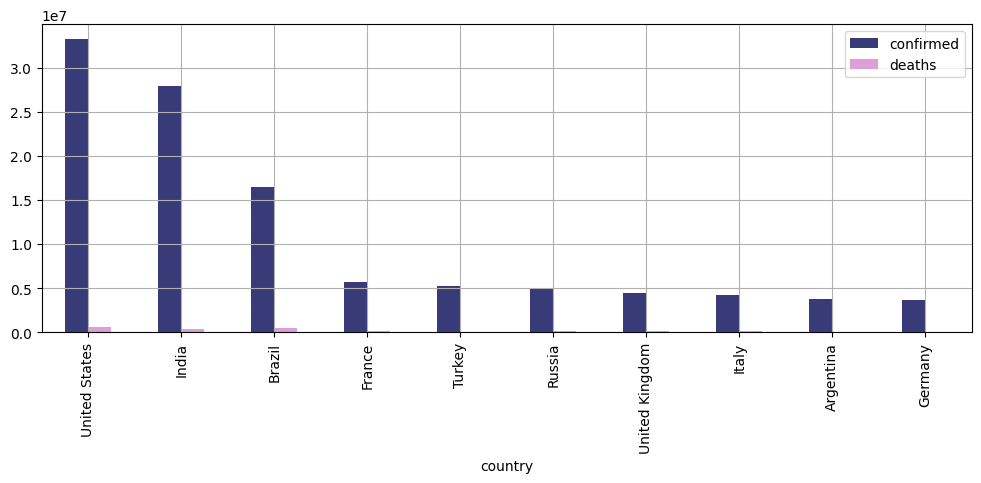

In [18]:
#многоуровневая столбчатая диаграмма
#Для этого сгруппируем данные по странам и вычислим последний зафиксированный показатель с помощью агрегирующего метода last()
grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['confirmed'])
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    legend=True,
    colormap='tab20b'
);

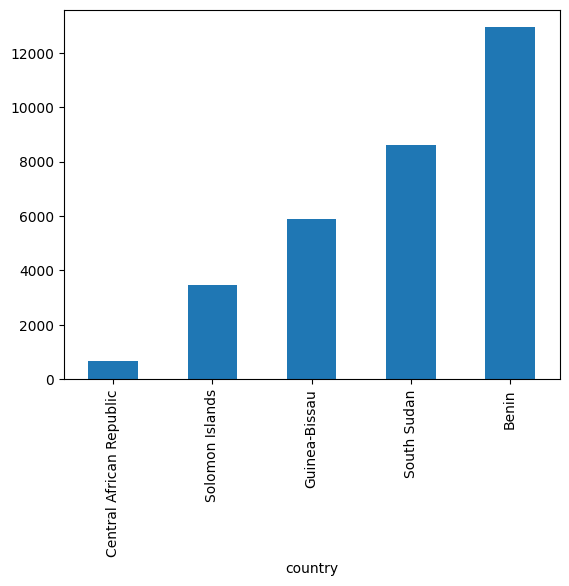

In [19]:
covid_df.groupby(['country'])['total_vaccinations'].last().nsmallest(5).plot(kind='bar');

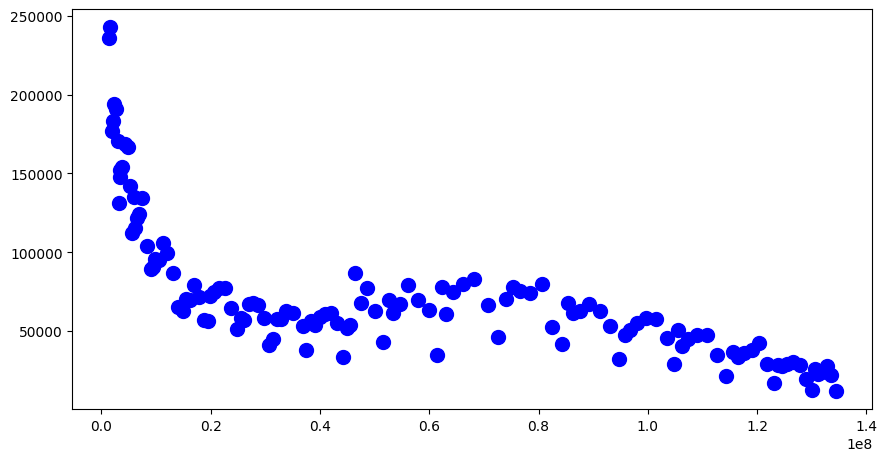

In [20]:
#диаграмма рассеяния
us_data = covid_df[covid_df['country'] == 'United States']

fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(
    x=us_data['people_fully_vaccinated'],
    y=us_data['daily_confirmed'],
    s=100,
    marker='o',
    c = 'blue'
);

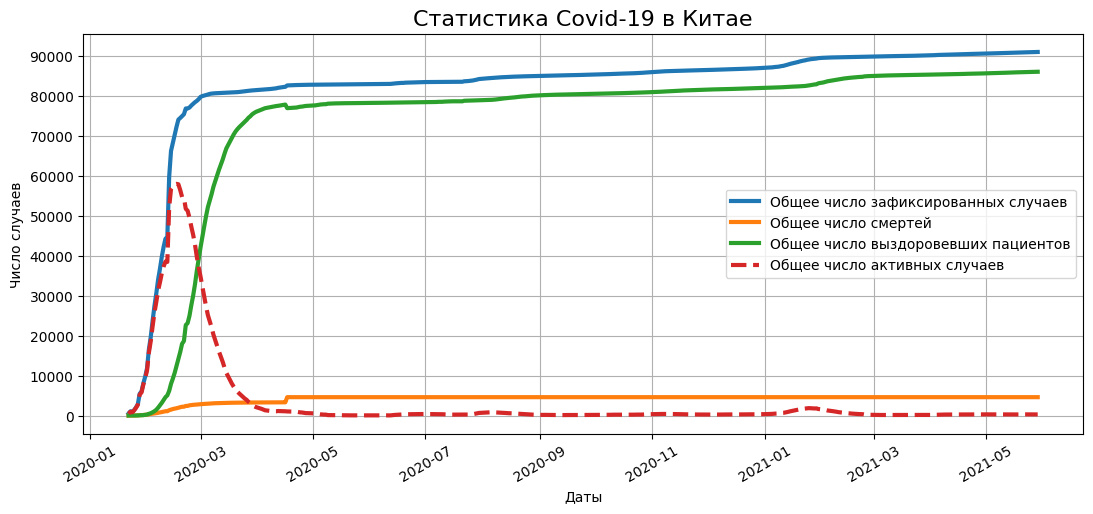

In [21]:
china_data = covid_df[covid_df['country'] == 'China'].sort_values(by='date')
china_grouped = china_data.groupby(['date'])[['confirmed', 'active', 'deaths', 'recovered']].sum()

#визуализация графиков
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(china_grouped['confirmed'], label='Общее число зафиксированных случаев', lw=3)
axes.plot(china_grouped['deaths'], label='Общее число смертей', lw=3)
axes.plot(china_grouped['recovered'], label='Общее число выздоровевших пациентов', lw=3)
axes.plot(china_grouped['active'], label='Общее число активных случаев', lw=3, linestyle='dashed')

#установка параметров отображения
axes.set_title('Статистика Covid-19 в Китае', fontsize=16)
axes.set_xlabel('Даты')
axes.set_ylabel('Число случаев')
axes.set_yticks(range(0, 100000, 10000))
axes.xaxis.set_tick_params(rotation=30)
axes.grid()
axes.legend();

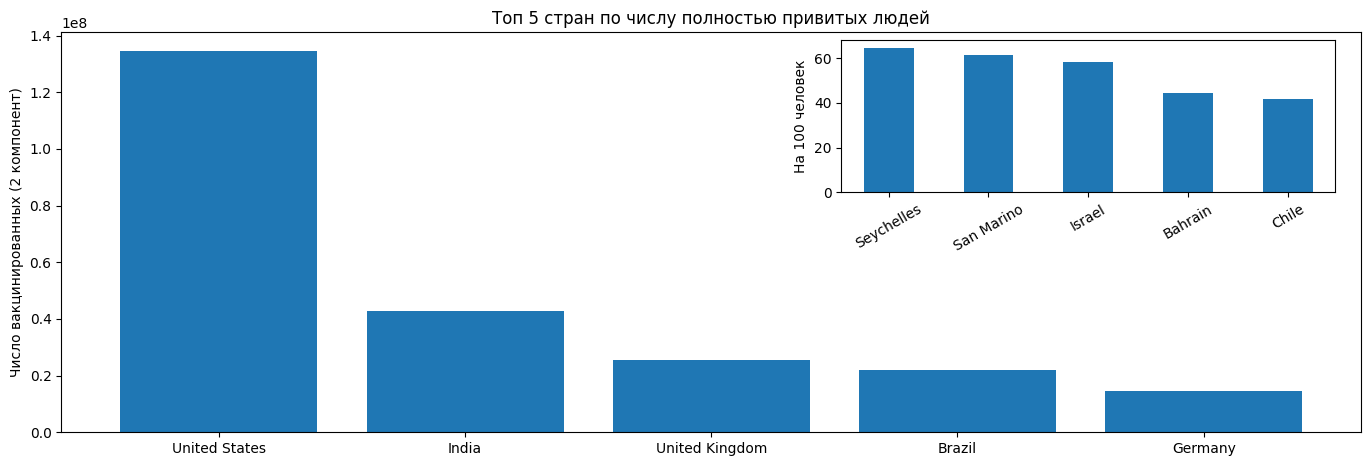

In [22]:
vacc_country = covid_df.groupby('country')['people_fully_vaccinated'].last().nlargest(5)
vacc_country_per_hundred = covid_df.groupby('country')['people_fully_vaccinated_per_hundred'].last().nlargest(5)

#визуализация главного графика
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(
    x = vacc_country.index,
    height = vacc_country,
    );
main_axes.set_ylabel('Число вакцинированных (2 компонент)')
main_axes.set_title('Топ 5 стран по числу полностью привитых людей')

#визуализация вспомогательного графика
insert_axes = fig.add_axes([0.6, 0.6, 0.38, 0.38])
insert_axes.bar(
    x = vacc_country_per_hundred.index,
    height = vacc_country_per_hundred,
    width=0.5
    );
insert_axes.set_ylabel('На 100 человек')
insert_axes.xaxis.set_tick_params(rotation=30)

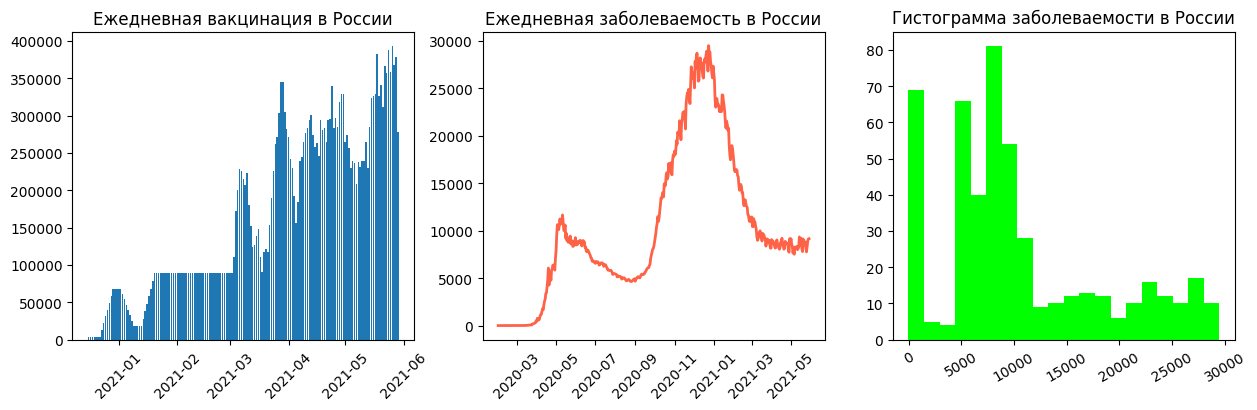

In [23]:
russia_data = covid_df[covid_df['country'] == 'Russia']

#визуализация систем координат
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
#столбчатая диаграмма
axes[0].bar(x=russia_data['date'],
            height=russia_data['daily_vaccinations'],
            label='Число вакцинированных')
axes[0].set_title('Ежедневная вакцинация в России')
axes[0].xaxis.set_tick_params(rotation=45)

#линейный график
axes[1].plot(russia_data['date'],
             russia_data['daily_confirmed'],
             label='Число заболевших',
             color='tomato', lw=2)
axes[1].set_title('Ежедневная заболеваемость в России')
axes[1].xaxis.set_tick_params(rotation=45)

#гистограмма
axes[2].hist(x=russia_data['daily_confirmed'],
             label=['Число заболевших'],
             color='lime', bins = 20)
axes[2].set_title('Гистограмма заболеваемости в России');
axes[2].xaxis.set_tick_params(rotation=30)

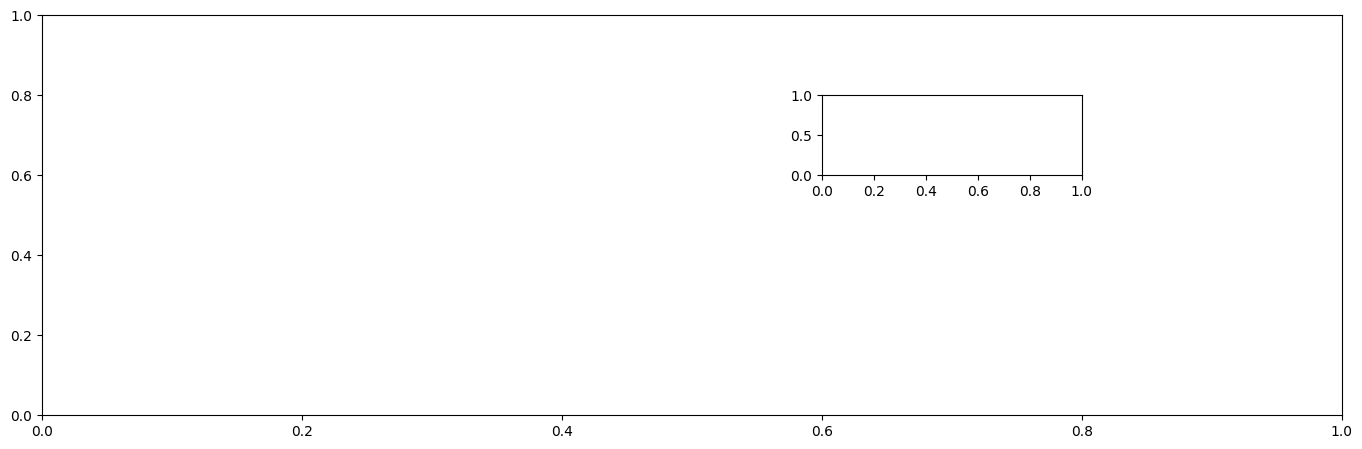

In [24]:
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
insert_axes = fig.add_axes([0.6, 0.6, 0.2, 0.2])

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.__version__

'0.13.2'

In [26]:
countries = ['Russia', 'Australia', 'Germany', 'Canada', 'United Kingdom']
croped_covid_df = covid_df[covid_df['country'].isin(countries)]

populations = pd.DataFrame([
    ['Canada', 37664517],
    ['Germany', 83721496],
    ['Russia', 145975300],
    ['Australia', 25726900],
    ['United Kingdom', 67802690]
    ],
    columns=['country', 'population']
)
croped_covid_df = croped_covid_df.merge(populations, on=['country'])
croped_covid_df['daily_confirmed_per_hundred'] = croped_covid_df['daily_confirmed'] / croped_covid_df['population'] * 100
croped_covid_df.head()

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines,death_rate,recover_rate,population,daily_confirmed_per_hundred
0,2020-01-23,Australia,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25726900,NaN
1,2020-01-25,Australia,4.0,0.0,0.0,4.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000016
2,2020-01-26,Australia,4.0,0.0,0.0,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000000
3,2020-01-27,Australia,5.0,0.0,0.0,5.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000004
4,2020-01-28,Australia,5.0,0.0,0.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000000


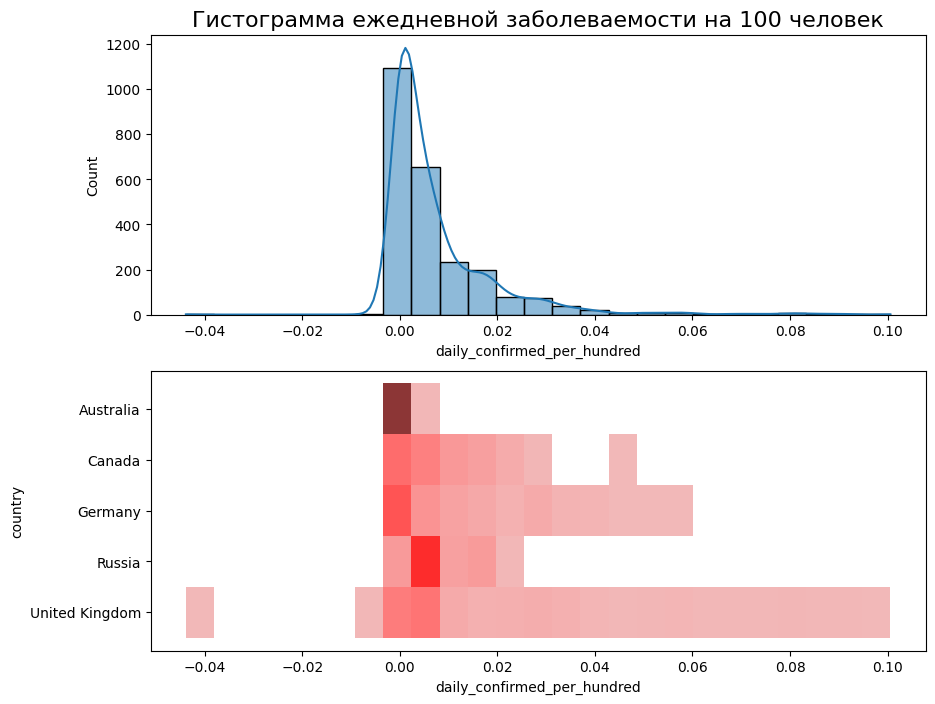

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    bins=25,
    kde=True,
    ax=axes[0]
);
axes[0].set_title('Гистограмма ежедневной заболеваемости на 100 человек', fontsize=16)#размер шрифта 16
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    y='country',
    bins=25,
    color='red',
    ax=axes[1]
);

/tmp/ipython-input-3739600223.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(


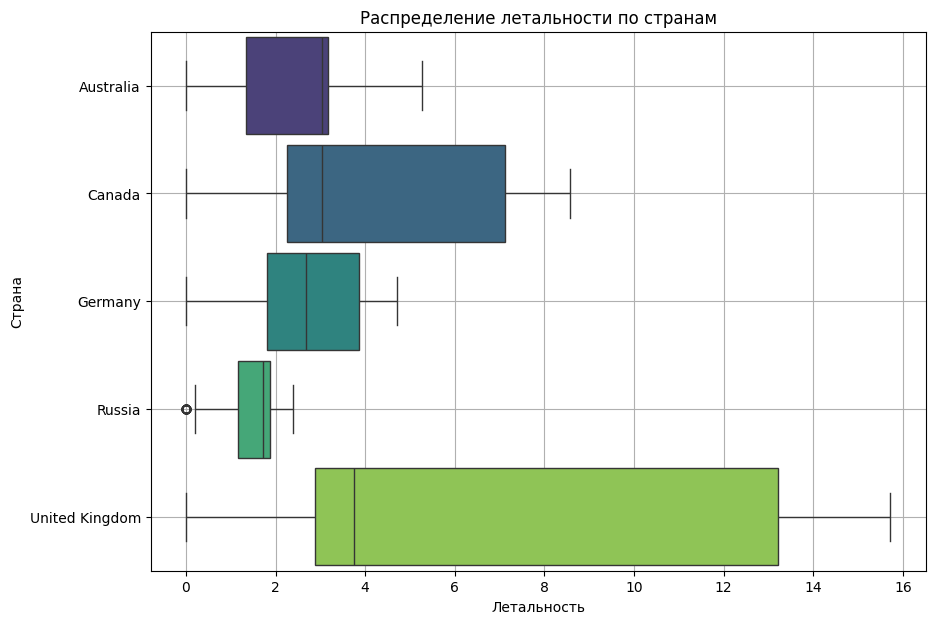

In [28]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='death_rate',
    orient='h',
    width=0.9,
    palette='viridis'#случайные цвета
)
boxplot.set_title('Распределение летальности по странам');
boxplot.set_xlabel('Летальность');
boxplot.set_ylabel('Страна');
boxplot.grid()

/tmp/ipython-input-220787031.py:6: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  barplot = sns.barplot(


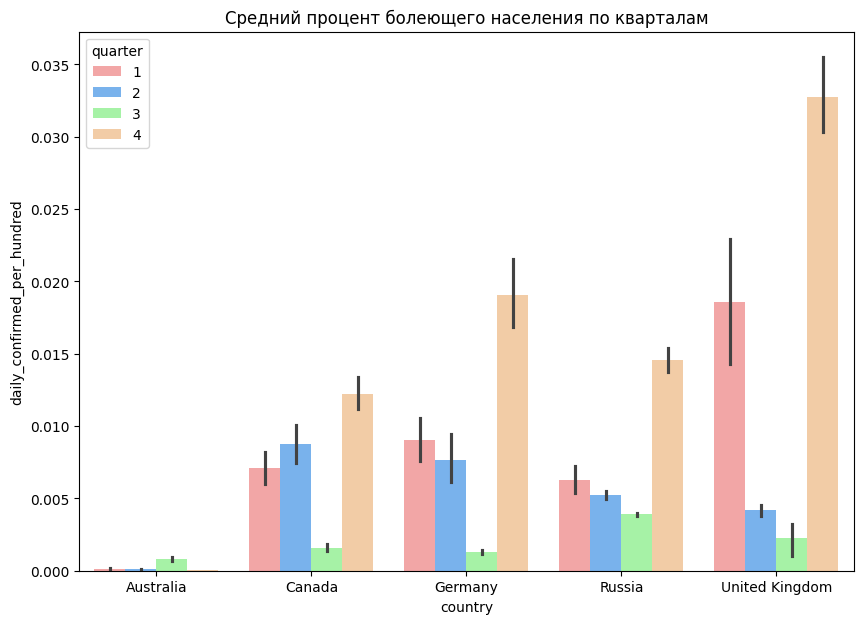

In [29]:
custom_palette = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC',
                  '#C4C4C4', '#FFD700', '#00CED1', '#FF6347', '#7B68EE']

fig = plt.figure(figsize=(10, 7))
croped_covid_df['quarter'] = croped_covid_df['date'].dt.quarter
barplot = sns.barplot(
    data=croped_covid_df,
    x='country',
    y='daily_confirmed_per_hundred',
    hue='quarter',
    palette=custom_palette#кастомные цвета из списка выше
)
barplot.set_title('Средний процент болеющего населения по кварталам');


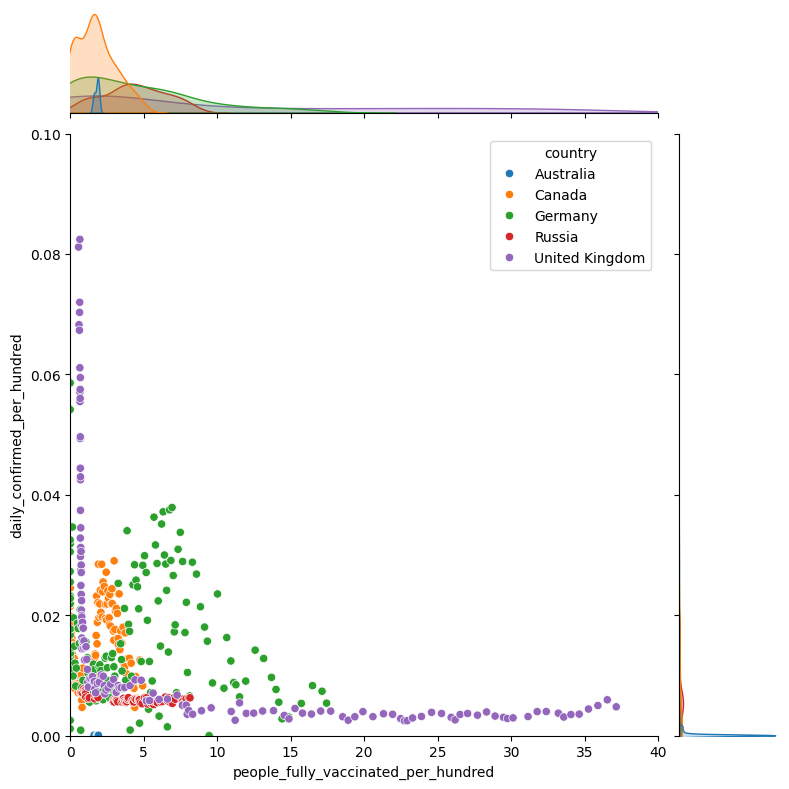

In [30]:
jointplot = sns.jointplot(
    data=croped_covid_df,
    x='people_fully_vaccinated_per_hundred',
    y='daily_confirmed_per_hundred',
    hue='country',
    xlim = (0, 40),
    ylim = (0, 0.1),
    height=8,
)

In [31]:
pivot = croped_covid_df.pivot_table(
    values='people_vaccinated_per_hundred',
    columns='date',
    index='country',
)
pivot.columns = pivot.columns.astype('string')
display(pivot)

date,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22,...,2021-05-20,2021-05-21,2021-05-22,2021-05-23,2021-05-24,2021-05-25,2021-05-26,2021-05-27,2021-05-28,2021-05-29
country,,,,,,,,,,,,,,,,,,,,,
Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12.40,12.69,12.88,13.28,13.73,14.18
Canada,NaN,0.0,0.00,0.01,0.02,0.03,0.03,0.03,0.05,0.07,...,48.10,49.25,50.14,50.89,51.77,52.39,53.05,53.95,54.99,55.71
Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.18,39.68,39.95,40.11,40.29,40.64,41.29,41.87,42.40,42.61
Russia,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.04,...,10.20,10.30,10.50,10.53,10.70,10.81,11.07,11.12,11.19,11.29
United Kingdom,0.13,NaN,NaN,NaN,NaN,NaN,NaN,0.99,NaN,NaN,...,55.01,55.33,55.63,55.82,55.99,56.27,56.61,56.99,57.29,57.56


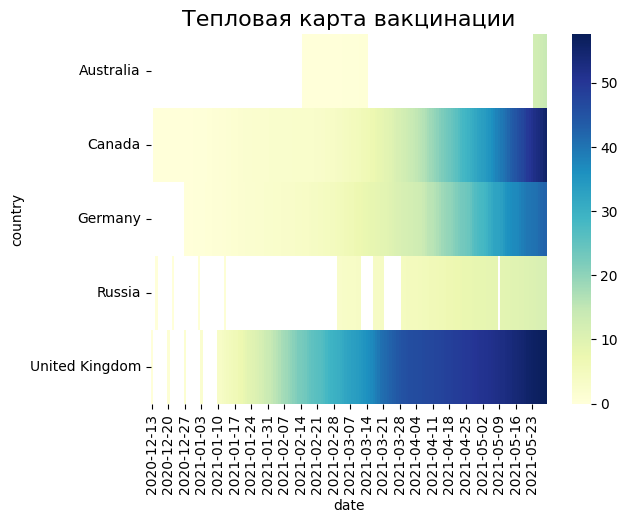

In [32]:
heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Тепловая карта вакцинации', fontsize=16);

In [33]:
croped_covid_df['confirmed_per_hundred'] = croped_covid_df['confirmed'] / croped_covid_df['population'] * 100

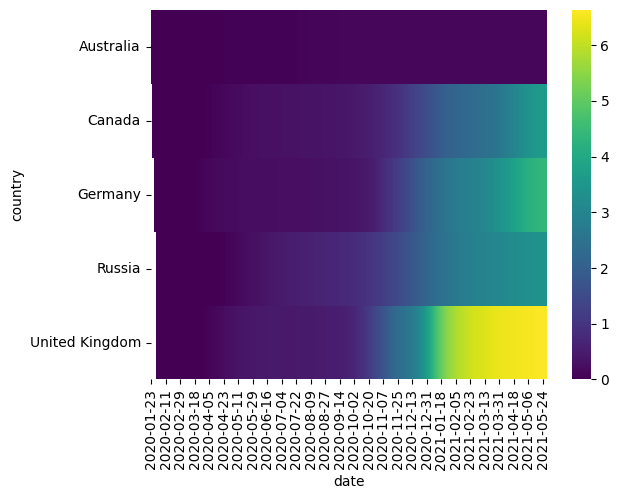

In [34]:
pivot1=croped_covid_df.pivot_table(
    values='confirmed_per_hundred',
    columns='date',
    index='country')
pivot1.columns = pivot1.columns.astype('string')
heatmap_c_p_h = sns.heatmap(data=pivot1, cmap='viridis')
heatmap.set_title('число заболевших в процентах от общего числа населения', fontsize=16);

/tmp/ipython-input-430950301.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(


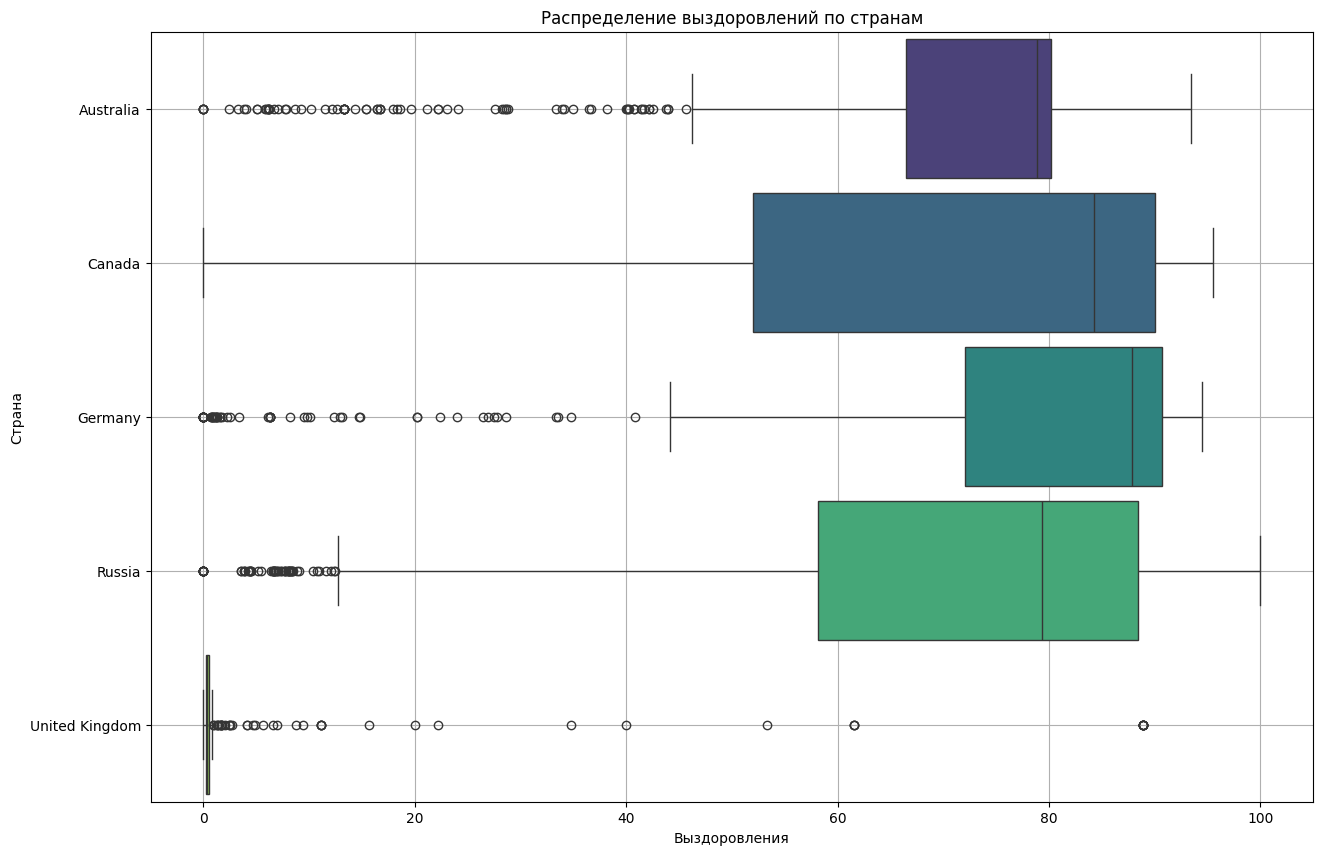

In [35]:
fig = plt.figure(figsize=(15, 10))
boxplot = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='recover_rate',
    orient='h',
    width=0.9,
    palette='viridis'#случайные цвета
);
boxplot.set_title('Распределение выздоровлений по странам');
boxplot.set_xlabel('Выздоровления');
boxplot.set_ylabel('Страна');
boxplot.grid();


In [36]:
#plotly
import plotly
import plotly.express as px

In [37]:
line_data = covid_df.groupby('date', as_index=False).sum()
fig = px.line(
    data_frame=line_data, #датафрейм
    x='date', #ось абсцисс
    y=['confirmed', 'recovered', 'deaths', 'active'], #ось ординат
    height=500, #высота
    width=1000, #ширина
    title='Confirmed, Recovered, Deaths, Active cases over Time' #заголовок
)
fig.show()

In [38]:
#считаем средний процент выздоровлений для каждой страны
bar_data = covid_df.groupby(
    by='country',
    as_index=False
)[['recover_rate']].mean().nlargest(10, columns=['recover_rate'])

#строим график
fig = px.bar(
    data_frame=bar_data, #датафрейм
    x="country", #ось x
    y="recover_rate", #ось y
    color='country', #расцветка в зависимости от страны
    text = 'recover_rate', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Top 10 Countries for Recovery Rate' #заголовок
)

#отображаем его
fig.show()

In [39]:
#считаем среднюю ежедневную заболеваемость по странам
treemap_data = covid_df.groupby(
    by='country',
    as_index=False
)[['daily_recovered']].mean()

#строим график
fig = px.treemap(
    data_frame=treemap_data, #датафрейм
    path=['country'], #кат. признак, для которого строится график
    values='daily_recovered', #параметр, который сравнивается
    height=500, #высота
    width=700, #ширина
    title='Daily Recovered Cases by Country' #заголовок
)

#отображаем его
fig.show()

In [40]:
#преобразуем даты в строки
choropleth_data = covid_df.sort_values(by='date')
choropleth_data['date'] = choropleth_data['date'].astype('string')

#строим график
fig = px.choropleth(
    data_frame=choropleth_data, #датафрейм
    locations="country", #столбец с локациями
    locationmode = "country names", #режим сопоставления локаций с базой plotly
    color="confirmed", #от чего зависит цвет
    animation_frame="date", #анимационный ползунок
    range_color=[0, 30e6],
    title='Global Spread of COVID-19', #заголовок
    width=800, #ширина
    height=500, #высота
    color_continuous_scale='Reds' #палитра цветов
)

#отображаем его
fig.show()

In [43]:
#фильтруем таблицу по странам
countries=['United States', 'Russia', 'United Kingdom', 'Brazil', 'France']
scatter_data = covid_df[covid_df['country'].isin(countries)]

#строим график
fig = px.scatter_3d(
    data_frame=scatter_data, #датафрейм
    x = 'daily_confirmed', #ось абсцисс
    y = 'daily_deaths', #ось ординат
    z = 'daily_vaccinations', #ось аппликат
    color='country', #расцветка в зависимости от страны
    log_x=True,
    log_y=True,
    width=1000,
    height=700
)

#отображаем его
fig.show()
import os
fig.write_html("scatter_3d.html")
print(f"Файл сохранен: {os.path.abspath('scatter_3d.html')}")
#fig.write_html("https://drive.google.com/drive/folders/15eFBNLU9nBhk2ctG6pRu0D5mwdFwakca?usp=drive_link/scatter_3d.html")


Файл сохранен: /content/scatter_3d.html
